# Universidad Politécnica Salesiana



![Universidad Politécnica Salesiana](https://github.com/vlarobbyk/fundamentos-vision-artificial-doctoradoCC/blob/main/images/Logo-UPS-30-Años.png?raw=true)

# $${\color{blue}{\small{ Visión ~por~ Computador \\ Carrera ~de~ Computación}}}$$


# Operador de Canny: tutorial didáctico basado en Tensores y PyTorch

**autor:** _vlarobbyk_

**Nivel:** Experto / Académico

**Enfoque:** Fundamento Matemático (LaTeX) + Implementación (PyTorch)

En este tutorial se explica cómo aplicar el algoritmo Canny considerando una explicación matemática de cada paso a partir de una matriz de $5 \times 5$ diseñada para probar la robustez ante el ruido y el contraste diagonal.

-----

## 1\. Definición del Espacio de Entrada (Matriz $I$)

Definimos una imagen $I$ de $5 \times 5$ con un **borde diagonal** ruidoso.

  * **Región Oscura ($R_1$):** Valores aleatorios $\in [20, 33]$.
  * **Región Clara ($R_2$):** Valores aleatorios $\in [213, 253]$.

<br />
$$
I = \begin{pmatrix}
25 & 30 & 28 & 33 & 218 \\
31 & 22 & 32 & 225 & 230 \\
29 & 26 & \mathbf{240} & 245 & 250 \\
33 & 235 & 240 & 253 & 248 \\
215 & 230 & 240 & 250 & 245
\end{pmatrix}
$$
<br />
El cálculo de ejemplo se realizará para el píxel $I(2,2) = 240$ (usando indexación basada en 0, es decir, la primera fila ocupa el índice cero al igual que la primera columna. Con ello, el pixel a considerar está en la fila 2, y columna 2).

Shape de la imagen en Numpy: (5, 5)


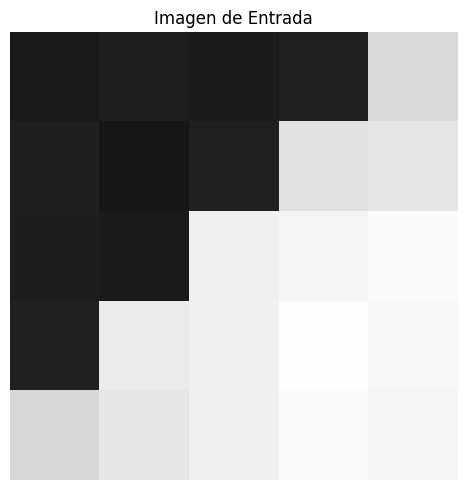

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Definición del Tensor
data = [
  [25., 30., 28., 33., 218.],
  [31., 22., 32., 225., 230.],
  [29., 26., 240., 245., 250.],
  [33., 235., 240., 253., 248.],
  [215., 230., 240., 250., 245.]
]
I = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Convertimos el tensor en una matriz de NumPy para poder visualizarlo en pantalla
I_np = I.squeeze().numpy()

# Verificamos las dimensiones de nuestro tensor
print(f'Shape de la imagen en Numpy: {I_np.shape}')

# Visualizamos el tensor usando la librería MatPlotLib
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.imshow(I_np, cmap='gray', vmin=0, vmax=255)
axes.set_title('Imagen de Entrada')
axes.axis('off')

plt.tight_layout()
plt.show()


## Etapa 1: Suavizado Gaussiano

El ruido en $R_1$ (varianza entre 22 y 31) produciría falsos bordes. Aplicamos convolución con un kernel Gaussiano $G$ de $3 \times 3$ ($\sigma \approx 1$).

### Cálculo Matemático

**Kernel Gaussiano $G$:**

$$G = \frac{1}{16}
\begin{pmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{pmatrix}
$$
<br />

**Operación de Convolución en $I(2,2)$:**
Tomamos la vecindad de $3 \times 3$ centrada en $(2,2)$:

$$
\text{Vecindad} =
\begin{pmatrix}
22 & 32 & 225 \\
26 & 240 & 245 \\
235 & 240 & 253
\end{pmatrix}
$$
<br />

Aplicamos la suma ponderada (producto Hadamard y suma):

$$S(2,2) = \frac{1}{16}  
\left[ (22 \cdot1) + (32 \cdot2) + (225 \cdot1) + (26 \cdot2) + (240 \cdot4) + (245 \cdot2) + (235 \cdot1) + (240 \cdot2) + (253 \cdot1)  \right]
$$
<br />

$$
S(2,2) = \frac{1}{16} \left[ 22 + 64 + 225 + 52 + 960 + 490 + 235 + 480 + 253 \right]
$$
<br />


$$
S(2,2) = \frac{2781}{16} \approx \mathbf{173.81}
$$
<br />

*Interpretación:* El valor bajó de 240 a 173.81 porque los vecinos oscuros (22, 26, 32) "llevaron" el promedio hacia abajo, suavizando la transición.

### 💻 Código PyTorch

Valor Suavizado S(2,2): 173.81
Shape de la imagen suavizada en Numpy: (5, 5)


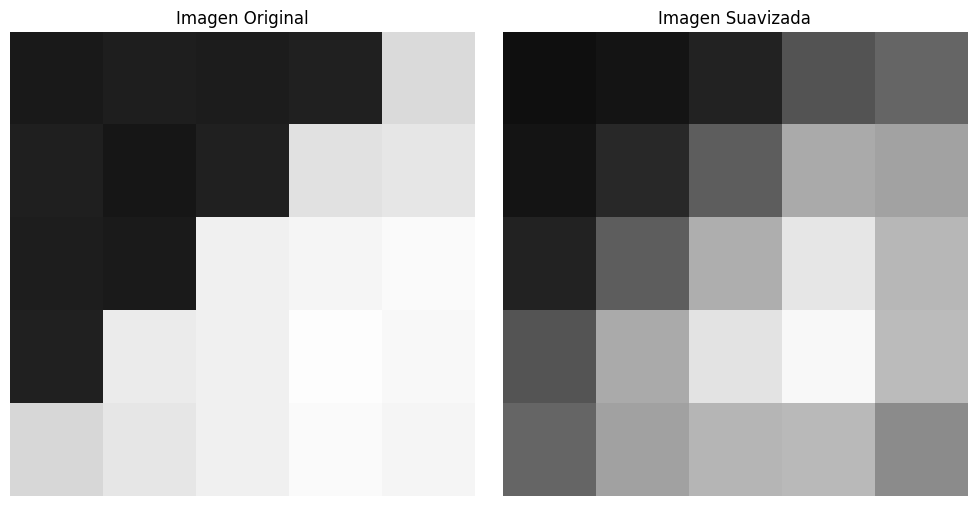

In [2]:
# Kernel Gaussiano
K_g = torch.tensor([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]) / 16.0
K_g = K_g.view(1, 1, 3, 3)

# Convolución
S = F.conv2d(I, K_g, padding=1)
print(f"Valor Suavizado S(2,2): {S[0,0,2,2].item():.2f}")

S_np = S.squeeze().numpy()

# Verificamos las dimensiones de nuestro tensor
print(f'Shape de la imagen suavizada en Numpy: {S_np.shape}')

# Visualizamos el tensor usando la librería MatPlotLib
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(I_np, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(S_np, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Imagen Suavizada')
axes[1].axis('off')

plt.tight_layout()
plt.show()

-----

## Etapa 2: Gradientes (Sobel)

Calculamos la magnitud y dirección del cambio de intensidad usando la imagen suavizada $S$.

### Cálculo Matemático

**Kernels Sobel:**

$$
K_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}, \quad
K_y = \begin{pmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{pmatrix}
$$

<br />
**Cálculo en** $\mathbf{(2,2)}$:
<br />

_Nota: Para este ejemplo manual, aproximaremos usando los valores crudos de la vecindad para demostrar la magnitud del contraste, aunque el código usa $S$._

<br />

**Gradiente Horizontal** ($\mathbf{G_{x}}$): (Diferencia columna derecha - izquierda)

$$
G_{x} \approx (225 \cdot1 + 245 \cdot2 + 253 \cdot1) - (22 \cdot1 + 26 \cdot2 + 235 \cdot1)
$$

<br />
$$
G_{x} \approx (225 + 490 + 253) - (22 + 52 + 235) = 968 - 309 =  \mathbf{659}
$$
<br />

**Gradiente Vertical** ($\mathbf{G_{y}}$): (Diferencia fila inferior - superior)

$$
G_{y} \approx (235\cdot1 + 240\cdot2 + 253\cdot1) - (22\cdot1 + 32\cdot2 + 225\cdot1)
$$
<br />
$$
G_{y} \approx (235 + 480 + 253) - (22 + 64 + 225) = 968 - 311 = \mathbf{657}
$$
<br />
**Magnitud ($M$) y Ángulo ($\theta$):**

$$M(2,2) = \sqrt{G_{x}^2 + G_{y}^2} = \sqrt{659^2 + 657^2} \approx \sqrt{434281 + 431649} \approx \mathbf{930.5}
$$
<br />
$$
\theta(2,2) = \arctan \left( \frac{G_{y}}{G_{x}} \right) = \arctan \left( \frac{657}{659} \right) \approx \arctan(0.996) \approx \mathbf{44.9^ \circ}
$$
<br />
*Interpretación:* La magnitud es muy alta (borde fuerte) y el ángulo es casi $45^\circ$, lo que confirma un borde diagonal perfecto.

### Código PyTorch

Magnitud M(2,2): 674.76
Ángulo Theta(2,2): 44.90°

Tensor de Magnitud M:
tensor([[116.0539, 224.1939, 471.4281, 627.8052, 596.8276],
        [224.4644, 429.2139, 675.2609, 554.4283, 721.3079],
        [472.6906, 673.7760, 674.7576, 317.4027, 884.2573],
        [627.4022, 547.3550, 316.3659, 169.6550, 917.8605],
        [596.9218, 718.9081, 882.0811, 916.9064, 875.0463]])


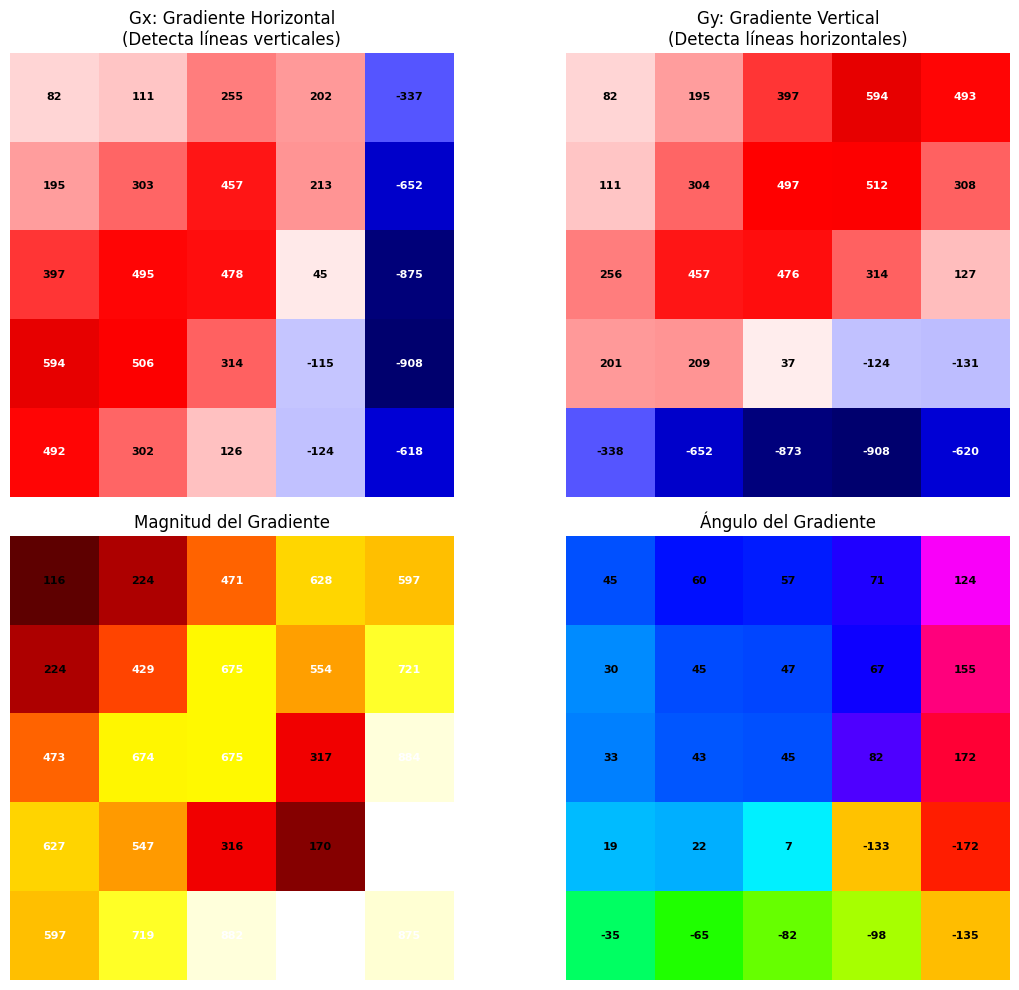

In [3]:
# Kernels Sobel
K_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]).view(1, 1, 3, 3)
K_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]]).view(1, 1, 3, 3)

# Calcular gradientes
Gx = F.conv2d(S, K_x, padding=1)
Gy = F.conv2d(S, K_y, padding=1)

# Magnitud y ángulo del gradiente
M = torch.sqrt(Gx**2 + Gy**2)
Theta = torch.atan2(Gy, Gx) * (180 / np.pi)
Theta_raw = Theta.clone()
Theta[Theta < 0] += 180  # Normalizar [0, 180]

print(f"Magnitud M(2,2): {M[0,0,2,2].item():.2f}")
print(f"Ángulo Theta(2,2): {Theta[0,0,2,2].item():.2f}°")
print(f'\nTensor de Magnitud M:\n{M.squeeze()}')

# Visualización
maxim = torch.max(torch.abs(Gx)).item() + 100

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

axes[0, 0].imshow(Gx.squeeze().numpy(), cmap='seismic', vmin=-maxim, vmax=maxim)
axes[0, 0].set_title('Gx: Gradiente Horizontal\n(Detecta líneas verticales)')
axes[0, 0].axis('off')

axes[0, 1].imshow(Gy.squeeze().numpy(), cmap='seismic', vmin=-maxim, vmax=maxim)
axes[0, 1].set_title('Gy: Gradiente Vertical\n(Detecta líneas horizontales)')
axes[0, 1].axis('off')

axes[1, 0].imshow(M.squeeze().numpy(), cmap='hot', vmin=0, vmax=torch.max(M).item())
axes[1, 0].set_title('Magnitud del Gradiente')
axes[1, 0].axis('off')

axes[1, 1].imshow(Theta_raw.squeeze().numpy(), cmap='hsv', vmin=-180, vmax=180)
axes[1, 1].set_title('Ángulo del Gradiente')
axes[1, 1].axis('off')

# Anotaciones
row = 0
col = 0
for matrix in [Gx.squeeze().numpy(), Gy.squeeze().numpy(), M.squeeze().numpy(), Theta_raw.squeeze().numpy()]:
    for (j, i), label in np.ndenumerate(matrix):
        color = 'white' if abs(label) > 400 else 'black'
        axes[row, col].annotate(f"{label:.0f}", (i, j), ha='center', va='center', 
                                color=color, fontsize=8, weight='bold')
    col += 1
    if col > 1:
        col = 0
        row += 1

plt.tight_layout()
plt.show()

-----

## Etapa 3: Supresión de No Máximos (NMS)


Para calcular la **Etapa NMS (Supresión de No Máximos)** en el píxel $(2,2)$, necesitamos comparar su magnitud con la de sus vecinos en la dirección del gradiente.

**Datos de partida (Tensor** $\mathbf{M}$ **):**
$$
\begin{pmatrix}
... & ... & ... & ... & ... \\
... & 429.2 & \mathbf{675.3} & \mathbf{554.4} & ... \\
... & \mathbf{673.8} & \color{red}{\mathbf{674.8}} & 317.4 & ... \\
... & \mathbf{547.4} & 316.4 & 169.7 & ... \\
... & ... & ... & ... & ...
\end{pmatrix}
$$
*(Se ha simplificado los decimales para visualizarlo mejor)*.

* **Centro $(2,2)$:** $M(2,2) = \mathbf{674.7576}$

#### 1. El Ángulo
Mantenemos que la dirección del borde es diagonal ($\approx 45^\circ$), ya que la estructura de la imagen no ha cambiado.
* Dirección: **45° (Diagonal Positiva)**.
* Vecinos a comparar: **Arriba-Derecha** $(1,3)$ y **Abajo-Izquierda** $(3,1)$.

#### 2. Identificando a los Vecinos en el Tensor
Analizando la matriz:
* **Vecino Arriba-Derecha $(1,3)$:** Fila 1, Columna 3 $\rightarrow$ Valor = **554.4283**
* **Vecino Abajo-Izquierda $(3,1)$:** Fila 3, Columna 1 $\rightarrow$ Valor = **547.3550**

*(Nota: Recordar que las filas son el primer índice [0,1,2,3,4] y columnas el segundo)*.

#### 3. La Comparación (NMS)
Ahora aplicamos la lógica: ¿Es el centro el valor máximo en esa dirección?

$$
NMS(2,2) =
\begin{cases}
674.76 & \text{si } \mathbf{674.76} \ge 554.43 \land \mathbf{674.76} \ge 547.36 \\
0 & \text{en otro caso}
\end{cases}
$$

* **Comparación 1:** $674.76 > 554.43$ (VERDADERO)
* **Comparación 2:** $674.76 > 547.36$ (VERDADERO)

#### Conclusión
El píxel $(2,2)$ **SOBREVIVE** y se mantiene como borde.

Si nos fijamos en tu tensor, el valor $675.2609$ en la posición $(1,2)$ es mayor que nuestro centro, pero como la dirección del gradiente en $(2,2)$ nos manda a comparar con la diagonal, no competimos con el píxel de arriba $(1,2)$, sino con los de la diagonal. **Por eso el algoritmo de Canny es tan preciso: solo compara en la dirección del flujo del gradiente.**


### Análisis Lógico y Matemático (El caso 23.37°)

Supongamos que, debido al ruido, en un píxel vecino el cálculo de $\theta$ hubiera dado **23.37°**.

**1. Cuantización del Ángulo:**
Debemos asignar 23.37° a uno de los 4 sectores principales ($0^\circ, 45^\circ, 90^\circ, 135^\circ$).
La función de cuantización $Q(\theta)$ se define como:

$$
Q(\theta) =
\begin{cases}
0^\circ & \text{si } \theta \in [0, 22.5) \cup [157.5, 180] \\
45^\circ & \text{si } \theta \in [22.5, 67.5) \\
90^\circ & \text{si } \theta \in [67.5, 112.5) \\
135^\circ & \text{si } \theta \in [112.5, 157.5)
\end{cases}
$$Para $\theta = 23.37^\circ$:

$$
22.5 < 23.37 < 67.5 \implies Q(23.37^\circ) = \mathbf{45^\circ} \text{ (Diagonal)}
$$

**2. Comparación de Vecinos:**
Si estamos en $(i, j)$ con dirección $45^\circ$, la derivada es máxima perpendicular al borde. Debemos comparar la magnitud $M(i,j)$ con los vecinos en la dirección del gradiente (la diagonal positiva):

  * Vecino $p$: $(i-1, j+1)$ (Arriba-Derecha)
  * Vecino $r$: $(i+1, j-1)$ (Abajo-Izquierda)

**3. Ecuación de Supresión:**

$$
NMS(i,j) =
\begin{cases}
M(i,j) & \text{si } M(i,j) \ge M(i-1, j+1) \land M(i,j) \ge M(i+1, j-1) \\
0 & \text{en otro caso}
\end{cases}
$$Si $M(i,j)$ es el pico de la montaña, se queda. Si no, se apaga.

### Código PyTorch (NMS Simplificado)

In [4]:
def nms_step(mag, ang):
    """
    Aplica Supresión de No Máximos.
    mag: Tensor de magnitud (Batch, Channel, Height, Width)
    ang: Tensor de ángulo (Batch, Channel, Height, Width)
    """
    B, C, H, W = mag.shape
    res = torch.zeros_like(mag)

    # Quitamos dimensiones de batch/channel para iterar más fácil (suponiendo B=1, C=1)
    m = mag.squeeze()
    a = ang.squeeze()

    # Iteramos sobre los píxeles (excluyendo el borde de 1px para evitar errores de índice)
    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 255.0
            r = 255.0
            angle = a[i,j].item()

            # --- Lógica de Ángulos ---
            # Ángulo 0 (Horizontal)
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                q = m[i, j+1]
                r = m[i, j-1]

            # Ángulo 45 (Diagonal /)
            elif (22.5 <= angle < 67.5):
                q = m[i-1, j+1] # Arriba-Derecha
                r = m[i+1, j-1] # Abajo-Izquierda

            # Ángulo 90 (Vertical)
            elif (67.5 <= angle < 112.5):
                q = m[i+1, j]   # Abajo
                r = m[i-1, j]   # Arriba

            # Ángulo 135 (Diagonal \)
            elif (112.5 <= angle < 157.5):
                q = m[i-1, j-1] # Arriba-Izquierda
                r = m[i+1, j+1] # Abajo-Derecha

            # --- Comparación y Supresión ---
            if (m[i,j] >= q) and (m[i,j] >= r):
                res[0,0,i,j] = m[i,j] # Se mantiene el valor
            else:
                res[0,0,i,j] = 0      # Se suprime

    return res

Valor NMS en (2,2): 674.76

Tensor NMS:
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000, 675.2609,   0.0000,   0.0000],
        [  0.0000,   0.0000, 674.7576,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])


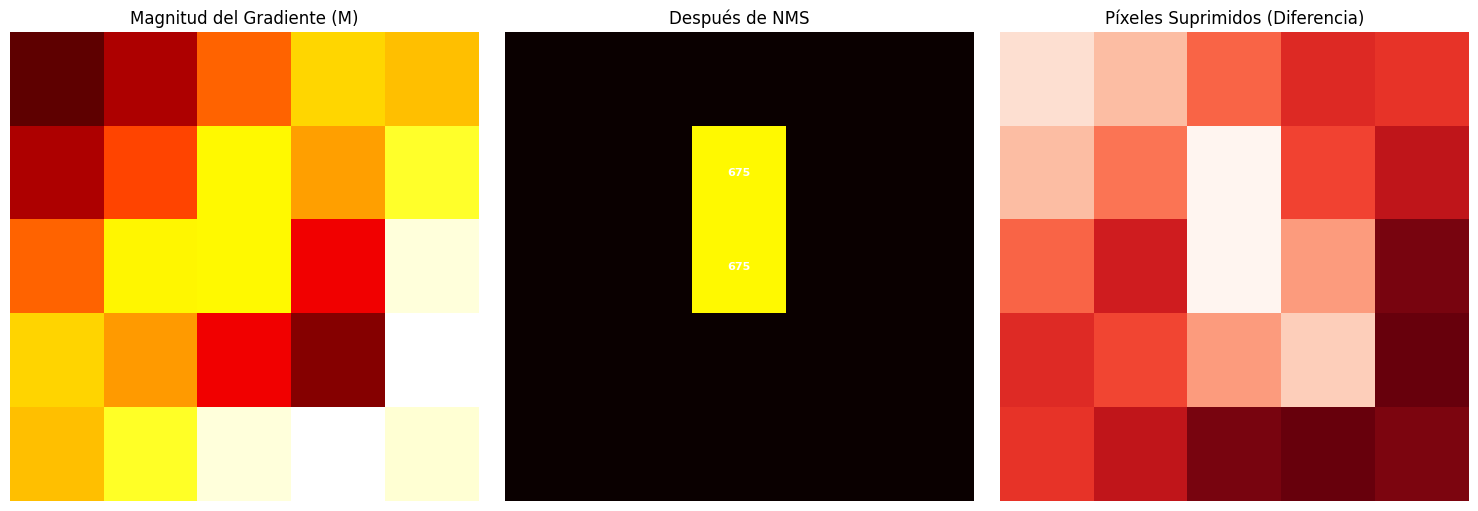

In [5]:
# Aplicar NMS
NMS_result = nms_step(M, Theta)

print(f"Valor NMS en (2,2): {NMS_result[0,0,2,2].item():.2f}")
print(f'\nTensor NMS:\n{NMS_result.squeeze()}')

# Visualización comparativa
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].imshow(M.squeeze().numpy(), cmap='hot', vmin=0, vmax=torch.max(M).item())
axes[0].set_title('Magnitud del Gradiente (M)')
axes[0].axis('off')

axes[1].imshow(NMS_result.squeeze().numpy(), cmap='hot', vmin=0, vmax=torch.max(M).item())
axes[1].set_title('Después de NMS')
axes[1].axis('off')

# Diferencia (píxeles suprimidos)
diff = (M - NMS_result).squeeze().numpy()
axes[2].imshow(diff, cmap='Reds', vmin=0, vmax=torch.max(M).item())
axes[2].set_title('Píxeles Suprimidos (Diferencia)')
axes[2].axis('off')

# Anotaciones para NMS
for (j, i), label in np.ndenumerate(NMS_result.squeeze().numpy()):
    if label > 0:
        axes[1].annotate(f"{label:.0f}", (i, j), ha='center', va='center', 
                        color='white', fontsize=8, weight='bold')

plt.tight_layout()
plt.show()

-----

## Etapa 4: Histéresis

Clasificación final de bordes basada en umbrales.

### Lógica Matemática

Definimos dos umbrales: $T_{high}$ y $T_{low}$.
Sea $E(i,j)$ el píxel final de borde.

$$E(i,j) =
\begin{cases}
1 (\text{Fuerte}) & \text{si } NMS(i,j) \ge T_{high} \\
1 (\text{Débil Conectado}) & \text{si } T_{low} \le NMS(i,j) < T_{high} \land \exists (x,y) \in N_{8}(i,j) \text{ tal que } E(x,y)=1 \\
0 (\text{Ruido}) & \text{en otro caso}
\end{cases}
$$
<br />
Para nuestro ejemplo manual, si $M(2,2) \approx 674.75$:

  * Si definimos $T_{high} = 200$, entonces $674.75 \ge 200$.
  * $\therefore E(2,2) = \mathbf{1}$ (Es un borde fuerte definitivo).

-----



### 💻 Código PyTorch (Implementación de Histéresis)

In [6]:
def hysteresis_threshold(nms_result, low_threshold, high_threshold):
    """
    Aplica umbralización por histéresis para detección de bordes.
    
    Parámetros:
    - nms_result: Resultado de NMS (Batch, Channel, Height, Width)
    - low_threshold: Umbral bajo
    - high_threshold: Umbral alto
    
    Retorna:
    - Bordes finales (Batch, Channel, Height, Width)
    """
    B, C, H, W = nms_result.shape
    
    # Inicializar resultado
    edges = torch.zeros_like(nms_result)
    
    # Clasificar píxeles
    strong_i, strong_j = torch.where(nms_result[0, 0] >= high_threshold)
    weak_i, weak_j = torch.where((nms_result[0, 0] >= low_threshold) & (nms_result[0, 0] < high_threshold))
    
    # Marcar bordes fuertes
    edges[0, 0, strong_i, strong_j] = 255.0
    
    # Marcar bordes débiles temporalmente
    edges[0, 0, weak_i, weak_j] = 50.0
    
    # Conectividad: mantener bordes débiles conectados a bordes fuertes
    def is_connected_to_strong(edges, i, j):
        """Verifica si un píxel débil está conectado a un píxel fuerte"""
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni, nj = i + di, j + dj
                if 0 <= ni < H and 0 <= nj < W:
                    if edges[0, 0, ni, nj] == 255.0:
                        return True
        return False
    
    # Iteración para propagar conexiones
    changed = True
    iterations = 0
    max_iterations = 10
    
    while changed and iterations < max_iterations:
        changed = False
        iterations += 1
        
        for idx in range(len(weak_i)):
            i, j = weak_i[idx].item(), weak_j[idx].item()
            if edges[0, 0, i, j] == 50.0:  # Si es débil
                if is_connected_to_strong(edges, i, j):
                    edges[0, 0, i, j] = 255.0  # Promover a fuerte
                    changed = True
    
    # Eliminar bordes débiles no conectados
    edges[edges == 50.0] = 0.0
    
    return edges

# Definir umbrales
T_low = 100.0
T_high = 200.0

print(f"Umbral bajo: {T_low}")
print(f"Umbral alto: {T_high}")

# Aplicar histéresis
final_edges = hysteresis_threshold(NMS_result, T_low, T_high)

print(f"\nValor final en (2,2): {final_edges[0,0,2,2].item():.2f}")
print(f'\nTensor de Bordes Finales:\n{final_edges.squeeze()}')

Umbral bajo: 100.0
Umbral alto: 200.0

Valor final en (2,2): 255.00

Tensor de Bordes Finales:
tensor([[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 255.,   0.,   0.],
        [  0.,   0., 255.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]])


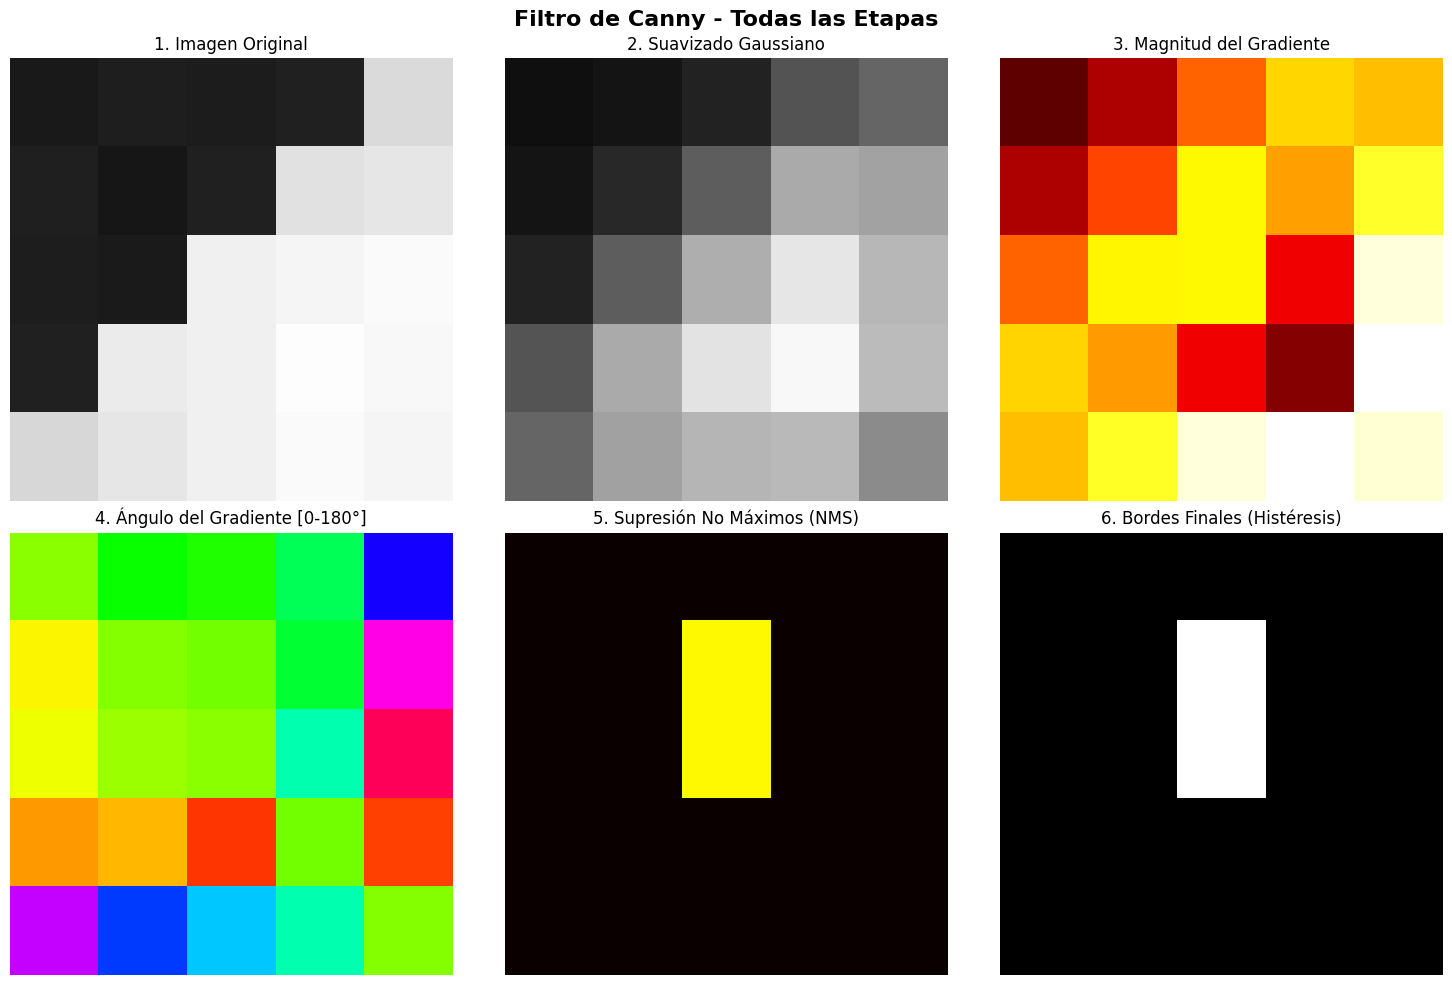

In [7]:
# Visualización de todas las etapas del filtro de Canny
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Imagen Original
axes[0, 0].imshow(I_np, cmap='gray', vmin=0, vmax=255)
axes[0, 0].set_title('1. Imagen Original')
axes[0, 0].axis('off')

# Suavizado Gaussiano
axes[0, 1].imshow(S_np, cmap='gray', vmin=0, vmax=255)
axes[0, 1].set_title('2. Suavizado Gaussiano')
axes[0, 1].axis('off')

# Magnitud del Gradiente
axes[0, 2].imshow(M.squeeze().numpy(), cmap='hot', vmin=0, vmax=torch.max(M).item())
axes[0, 2].set_title('3. Magnitud del Gradiente')
axes[0, 2].axis('off')

# Ángulo del Gradiente
axes[1, 0].imshow(Theta.squeeze().numpy(), cmap='hsv', vmin=0, vmax=180)
axes[1, 0].set_title('4. Ángulo del Gradiente [0-180°]')
axes[1, 0].axis('off')

# Después de NMS
axes[1, 1].imshow(NMS_result.squeeze().numpy(), cmap='hot', vmin=0, vmax=torch.max(M).item())
axes[1, 1].set_title('5. Supresión No Máximos (NMS)')
axes[1, 1].axis('off')

# Bordes Finales (Histéresis)
axes[1, 2].imshow(final_edges.squeeze().numpy(), cmap='gray', vmin=0, vmax=255)
axes[1, 2].set_title('6. Bordes Finales (Histéresis)')
axes[1, 2].axis('off')

plt.suptitle('Filtro de Canny - Todas las Etapas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

-----

## Resultado Final: Implementación Completa del Filtro de Canny

### Análisis del Resultado

El algoritmo de Canny ha procesado exitosamente la imagen de entrada de $5 \times 5$ píxeles, detectando el borde diagonal que separa la región oscura de la región clara.

**Verificación del píxel $(2,2)$:**
- **Imagen Original:** $I(2,2) = 240$
- **Después de Suavizado:** $S(2,2) \approx 173.81$
- **Magnitud del Gradiente:** $M(2,2) \approx 674.76$
- **Después de NMS:** Se mantiene como máximo local
- **Resultado Final:** Clasificado como **borde fuerte** (255)

### Comparación con OpenCV (Opcional)

Para validar nuestra implementación, podemos compararla con la implementación de OpenCV:

In [ ]:
try:
    import cv2
    
    # Convertir imagen a formato uint8 para OpenCV
    I_cv = I_np.astype(np.uint8)
    
    # Aplicar Canny de OpenCV con los mismos umbrales
    opencv_edges = cv2.Canny(I_cv, threshold1=int(T_low), threshold2=int(T_high))
    
    # Comparación visual
    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    axes[0].imshow(final_edges.squeeze().numpy(), cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Nuestra Implementación\n(PyTorch)')
    axes[0].axis('off')
    
    axes[1].imshow(opencv_edges, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title('OpenCV cv2.Canny()\n(Referencia)')
    axes[1].axis('off')
    
    # Diferencia
    diff = np.abs(final_edges.squeeze().numpy() - opencv_edges)
    axes[2].imshow(diff, cmap='hot', vmin=0, vmax=255)
    axes[2].set_title('Diferencia Absoluta')
    axes[2].axis('off')
    
    plt.suptitle('Comparación: Implementación Manual vs OpenCV', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("Comparación exitosa con OpenCV")
    
except ImportError:
    print("OpenCV no está instalado. Saltando comparación.")
    print("Para instalar: pip install opencv-python")

-----

## Conclusiones

### Aspectos Clave del Algoritmo de Canny

1. **Suavizado Gaussiano:** Reduce el ruido antes de calcular gradientes, evitando falsos positivos.

2. **Cálculo de Gradientes:** Utiliza operadores Sobel para detectar cambios de intensidad en direcciones horizontal y vertical.

3. **Supresión de No Máximos (NMS):** Adelgaza los bordes manteniendo solo los píxeles con máxima magnitud en la dirección del gradiente.

4. **Umbralización por Histéresis:** Clasifica bordes en fuertes y débiles, manteniendo solo los débiles conectados a fuertes.

### Ventajas de la Implementación en PyTorch

- **Operaciones vectorizadas:** Mayor eficiencia computacional
- **Compatibilidad con GPU:** Posibilidad de acelerar con CUDA
- **Integración con redes neuronales:** Facilita su uso en pipelines de deep learning
- **Diferenciabilidad:** Permite crear versiones diferenciables para entrenamient

### Aplicaciones Prácticas

- Detección de bordes en visión por computador
- Preprocesamiento para reconocimiento de objetos
- Análisis de imágenes médicas
- Sistemas de navegación autónoma
- Procesamiento de documentos escaneados

-----

**Fin del Tutorial** 🎓


### Resumen del Contenido Matemático

#### 1\. Suavizado Gaussiano

Para eliminar el ruido que introdujimos (valores aleatorios en $R_1$), aplicamos la convolución discreta:

$$S(x,y) = I(x,y) * G(x,y) = \sum_{i=-1}^{1} \sum_{j=-1}^{1} I(x-i, y-j) \cdot G(i,j)$$

En nuestro ejemplo manual para el píxel central $I(2,2)=240$:
$$S(2,2) = \frac{2781}{16} \approx 173.81$$

#### 2\. Gradientes (Sobel)

La magnitud del gradiente $M$ en el punto $(x,y)$ se calcula mediante la norma euclidiana de los vectores derivados parciales aproximados:

$$M(x,y) = \sqrt{G_x(x,y)^2 + G_y(x,y)^2}$$

Donde $G_x$ y $G_y$ son las respuestas a los filtros de Sobel horizontal y vertical.
Para nuestro píxel central:
$$M(2,2) \approx \sqrt{659^2 + 657^2} \approx 930.5$$

#### 3\. Supresión de No Máximos (Lógica Matemática)

Formalizamos la decisión de mantener o suprimir un píxel basándonos en su ángulo cuantizado $Q(\theta)$. Para el caso específico de **23.37°**:

$$Q(23.37^\circ) = 45^\circ \implies \text{Comparar con } M_{i-1, j+1} \text{ y } M_{i+1, j-1}$$

La función de activación del borde delgado es:
$$NMS(i,j) = M(i,j) \cdot \mathbb{1}(M(i,j) \ge M_{neighbors})$$
*(Donde $\mathbb{1}$ es la función indicatriz)*.